In [3]:
"""
This module contains functions for loading a pdb file and calculating
the atomic density fields for different atom types. The fields can then be
used for plotting, or to send into the convolutional neural network.
"""

import os
import sys
import torch
import numpy as np

from biopandas.pdb import PandasPdb
from biopandas.mol2 import PandasMol2

import pickle

import numpy as np

import pybel
from math import ceil, sin, cos, sqrt, pi
from itertools import combinations
from silx.io.dictdump import dicttoh5
import h5py
import click
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from   scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
from   numpy.linalg import eig, inv

STD = 0.3455

In [4]:
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device_type

'cpu'

In [5]:
def load_pdb(path):

    pdb = PandasPdb().read_pdb(path)
# This just creates a dataframe from the pdb file using biopandas
#print('This is vars',vars(pdb))
    pdf = pdb.df['ATOM']
    x_coords = pdf['x_coord'].values
    y_coords = pdf['y_coord'].values
    z_coords = pdf['z_coord'].values
    atom_types = pdf['atom_name'].values
    residue_names = pdf['residue_name'].values
    
    pro_dict = generate_dict(x_coords, y_coords, z_coords, atom_types, residue_names)
    # add a value to the dictionary, which is all of the atomic coordinates just
    # shifted to the origin
    #protein_dict = shift_coords(protein_dict)

    return pro_dict



def load_mol2(path):
    
    mol = PandasMol2().read_mol2(path)
    pdf = mol
    x_coords = pdf.df['x'].values
    y_coords = pdf.df['y'].values
    z_coords = pdf.df['z'].values
    atom_types = pdf.df['atom_name'].values
    residue_names = pdf.df['subst_name'].values
    partial_charge = pdf.df['charge'].values
    smarts_notation = next(pybel.readfile('mol2', path))
    
    pro_dict = generate_dict(x_coords, y_coords, z_coords, atom_types, residue_names)
    heavy_pos = heavy_atom_positions(x_coords, y_coords, z_coords, atom_types)

    pro_dict['charge'] = partial_charge
    pro_dict['smarts'] = smarts_notation
    pro_dict['heavy_atom_positions'] = heavy_pos

    # add a value to the dictionary, which is all of the atomic coordinates just
    # shifted to the origin
    #protein_dict = shift_coords(protein_dict)

    return pro_dict
    
def generate_dict(x, y, z, a_types, res_names):
    
    positions = []
    for i, xi in enumerate(x):
        position_tuple = (x[i], y[i], z[i])
        positions.append(position_tuple)
    positions = np.array(positions)

    # names of all the atoms contained in the protein
    
    num_atoms = len(a_types)
    atom_type_set = np.unique(a_types)
    num_atom_types = len(atom_type_set)

    # residue names
    
    residue_set = np.unique(res_names)

    pro_dict = {'x_coords':x, 'y_coords':y, 'z_coords':z,
                    'positions':positions, 'atom_types':a_types,
                    'num_atoms':num_atoms, 'atom_type_set':atom_type_set,
                    'num_atom_types':num_atom_types, 'residues':res_names,
                    'residue_set':residue_set}
    
    return pro_dict

def heavy_atom_positions(x, y, z, a_types):
    
    positions = []
    for i, xi in enumerate(x):
        if a_types[i].startswith('H'):
            pass
        else:
            position_tuple = (x[i], y[i], z[i])
            positions.append(position_tuple)
    positions = np.array(positions)
    
    return positions


def load_input(path, ligand=False):
    """
    Loads all of the atomic positioning/type arrays from a pdb/mol2 file.
    The arrays can then be transformed into density (or "field") tensors before
        being sent through the neural network.
    Parameters:
        path (str, required): The full path to the pdb file being voxelized.
    Returns:
        dictionary: A dictionary containing the following arrays from
            the pdb file: num_atoms, atom_types, positions, atom_type_set,
            xcoords, ycoords, zcoords, residues, residue_set
    """
    
    file_type = path.split('.')[-1]
    
    if file_type == 'pdb':
        protein_dict = load_pdb(path)
    
    elif file_type == 'mol2':
        protein_dict = load_mol2(path)
    else:
        raise ValueError('Need a pdb or mol2 file')
    # atomic coordinates
    if ligand == True:
        ligand_file = path.split('_')[:-1][0] + '_ligand.mol2'
        ligand_dict = load_mol2(ligand_file)
        mid_points = shift_coords(protein_dict, lig_dict=ligand_dict)
        #mid_points = shift_coords(ligand_dict, lig_dict=None)
        protein_dict['shifted_positions'] = protein_dict['positions'] - mid_points
        ligand_dict['shifted_positions'] = ligand_dict['positions'] - mid_points
        
        return protein_dict, ligand_dict
    else:
        mid_points = shift_coords(protein_dict)
        protein_dict['shifted_positions'] = protein_dict['positions'] - mid_points
        
        return protein_dict
        

    # create an array containing tuples of x,y,z for every atom
    
def get_extreme_values(name_dict):
    
    x_ext = np.array([name_dict['x_coords'].min(), name_dict['x_coords'].max()])
    y_ext = np.array([name_dict['y_coords'].min(), name_dict['y_coords'].max()])
    z_ext = np.array([name_dict['z_coords'].min(), name_dict['z_coords'].max()])
    
    return x_ext, y_ext, z_ext

def shift_coords(pro_dict, lig_dict=None):
    """
    This function shifts the coordinates of a protein so that it's coordinates are in the center
    of the field tensor.
    Parameters:
        protein_dict (dict): A dictionary of information from the first part of the load_input function.
    Returns:
        dictionary: The original protein dict but with an added value containing
            the coordinates of the protein shifted to the origin.
    """
    # find the extreme x, y, and z values that exist in the protein atomic coordinates
 
    x_extremes, y_extremes, z_extremes = get_extreme_values(pro_dict)
        

    if lig_dict:
        x_pro, y_pro, z_pro = get_extreme_values(pro_dict)
        x_lig, y_lig, z_lig = get_extreme_values(lig_dict)
        x_extremes, y_extremes, z_extremes = get_extreme_values(lig_dict)
        
#         x_extremes = np.array([np.min(np.concatenate([x_pro, x_lig])), np.max(np.concatenate([x_pro, x_lig]))])
#         y_extremes = np.array([np.min(np.concatenate([y_pro, y_lig])), np.max(np.concatenate([y_pro, y_lig]))])
#         z_extremes = np.array([np.min(np.concatenate([z_pro, z_lig])), np.max(np.concatenate([z_pro, z_lig]))])
        
        #x_val = np.concatenate(x_pro, x_lig)
        #print(x_extremes)
    # calculate the midpoints of the extremes
    midpoints = [np.sum(x_extremes)/2, np.sum(y_extremes)/2, np.sum(z_extremes)/2]
#     print(x_extremes, y_extremes, z_extremes)

    # shift the coordinates by the midpoints of those extremes (center the protein on the origin)
#     protein_dict['shifted_positions'] = protein_dict['positions'] - midpoints

    return midpoints

In [6]:
from __future__ import division
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
import numpy as np
from numpy import linalg
from random import random

class EllipsoidTool:
    """Some stuff for playing with ellipsoids"""
    def __init__(self): pass
    
    def getMinVolEllipse(self, P=None, tolerance=0.01):
        """ Find the minimum volume ellipsoid which holds all the points
        
        Based on work by Nima Moshtagh
        http://www.mathworks.com/matlabcentral/fileexchange/9542
        and also by looking at:
        http://cctbx.sourceforge.net/current/python/scitbx.math.minimum_covering_ellipsoid.html
        Which is based on the first reference anyway!
        
        Here, P is a numpy array of N dimensional points like this:
        P = [[x,y,z,...], <-- one point per line
             [x,y,z,...],
             [x,y,z,...]]
        
        Returns:
        (center, radii, rotation)
        
        """
        (N, d) = np.shape(P)
        d = float(d)
    
        # Q will be our working array
        Q = np.vstack([np.copy(P.T), np.ones(N)]) 
        QT = Q.T
        
        # initializations
        err = 1.0 + tolerance
        u = (1.0 / N) * np.ones(N)

        # Khachiyan Algorithm
        while err > tolerance:
            V = np.dot(Q, np.dot(np.diag(u), QT))
            M = np.diag(np.dot(QT , np.dot(linalg.inv(V), Q)))    # M the diagonal vector of an NxN matrix
            j = np.argmax(M)
            maximum = M[j]
            step_size = (maximum - d - 1.0) / ((d + 1.0) * (maximum - 1.0))
            new_u = (1.0 - step_size) * u
            new_u[j] += step_size
            err = np.linalg.norm(new_u - u)
            u = new_u

        # center of the ellipse 
        center = np.dot(P.T, u)
    
        # the A matrix for the ellipse
        A = linalg.inv(
                       np.dot(P.T, np.dot(np.diag(u), P)) - 
                       np.array([[a * b for b in center] for a in center])
                       ) / d
                       
        # Get the values we'd like to return
        U, s, rotation = linalg.svd(A)
        radii = 1.0/np.sqrt(s)
        
        return (center, radii, rotation)

    def getEllipsoidVolume(self, radii):
        """Calculate the volume of the blob"""
        return 4./3.*np.pi*radii[0]*radii[1]*radii[2]

    def plotEllipsoid(self, center, radii, rotation, ax=None, plotAxes=False, cageColor='b', cageAlpha=0.2):
        """Plot an ellipsoid"""
        make_ax = ax == None
        if make_ax:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            
        u = np.linspace(0.0, 2.0 * np.pi, 100)
        v = np.linspace(0.0, np.pi, 100)
        
        # cartesian coordinates that correspond to the spherical angles:
        x = radii[0] * np.outer(np.cos(u), np.sin(v))
        y = radii[1] * np.outer(np.sin(u), np.sin(v))
        z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
        # rotate accordingly
        for i in range(len(x)):
            for j in range(len(x)):
                [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center
    
        if plotAxes:
            # make some purdy axes
            axes = np.array([[radii[0],0.0,0.0],
                             [0.0,radii[1],0.0],
                             [0.0,0.0,radii[2]]])
            # rotate accordingly
            for i in range(len(axes)):
                axes[i] = np.dot(axes[i], rotation)
    
    
            # plot axes
            for p in axes:
                X3 = np.linspace(-p[0], p[0], 100) + center[0]
                Y3 = np.linspace(-p[1], p[1], 100) + center[1]
                Z3 = np.linspace(-p[2], p[2], 100) + center[2]
                ax.plot(X3, Y3, Z3, color=cageColor)
    
        # plot ellipsoid
        ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color=cageColor, alpha=cageAlpha)
        
        if make_ax:
            plt.show()
            plt.close(fig)
            del fig
            
    def rotate_position(self, ligand_heavy, ligand_all, protein_all, center, rotation_mat):


        ligand_heavy = ligand_heavy - center
        ligand_heavy_rotated = np.dot(ligand_heavy, rotation_mat)

        ligand_all = ligand_all - center 
        ligand_rotated = np.dot(ligand_all, rotation_mat)

        protein_all = protein_all - center 
        protein_rotated = np.dot(protein_all, rotation_mat)

        return protein_rotated, ligand_rotated, ligand_heavy_rotated

In [7]:
path = '1a1e_ligand.mol2'
path.split('_')[:-1][0]

'1a1e'

In [26]:
def grid_positions(grid_array):
    """
    This function returns the 3D meshgrids of x, y and z positions.
    These cubes will be flattened, then used as a reference coordinate system
    to place the actual channel densities into.
    Parameters:
        grid_positions (pytorch tensor): lineraly spaced grid
    Returns:
        array: meshgrid array of the x, y and z positions.
    """
    xgrid = grid_array.view(-1, 1, 1).repeat(1, len(grid_array), len(grid_array))
    ygrid = grid_array.view(1, -1, 1).repeat(len(grid_array), 1, len(grid_array))
    zgrid = grid_array.view(1, 1, -1).repeat(len(grid_array), len(grid_array), 1)
    return (xgrid, ygrid, zgrid)

# def norm_properties(prop, channel):
    
#     if channel == 'hyb':
#         max_prop = 3
#         min_prop = 0
#     elif channel == 'heterovalence':
#         max_prop = 4
#         min_prop = 0
#     elif channel == 'heavyvalence':
#         max_prop = 4
#         min_prop = 0
#     else:
#         max_prop = 2.276
#         min_prop = -1.167
#         # clamping the charge value within a range
#         # the range is chosen from ligand data
#         prop[prop > 2.276] = 2.276
#         prop[prop < -1.166] = -1.167
    
#     norm_prop = (prop-min_prop)/(max_prop-min_prop)
    
#     return norm_prop

def get_prop_values(prop_name, pro_dict, lig_dict=None, channel='hyb'):
    
    
    prop = []
    for atom in pro_dict['smarts']:

#atom.__getattribute__(prop)
        prop.append(atom.__getattribute__(prop_name[np.int(np.where(prop_name == channel)[0])]))

    if lig_dict:
        for atom in lig_dict['smarts']:
#atom.__getattribute__(prop)
            prop.append(atom.__getattribute__(prop_name[np.int(np.where(prop_name == channel)[0])]))

    prop = np.array(prop)
    if channel == 'partialcharge':
        prop = np.where(prop < 5, prop, 5)
        prop = prop / STD
    
    return prop


def make_fields(protein_dict, channels, bin_size, num_bins, ligand_dict=None, ligand=False, feature_type='nearest'):
    """
    This function takes a protein dict (from load_input function) and outputs a
        large tensor containing many atomic "fields" for the protein.
    The fields describe the atomic "density" (an exponentially decaying function
        of number of atoms in a voxel) of any particular atom type.
    Parameters:
        protein_dict (dict, requred): dictionary from the load_input function
        channels (list-like, optional): the different atomic densities we want fields for
            theoretically these different fields provide different chemical information
            full list of available channels is in protein_dict['atom_type_set']
        bin_size (float, optional): the side-length (angstrom) of a given voxel in the box
            that atomic densities are placed in
        num_bins (int, optional): how big is the cubic field tensor side length
            (i.e., num_bins is box side length)
    Returns:
        dictionary: A list of atomic density tensors (50x50x50), one for each
            channel in channels
    """
    # sets of allowed filters to build channels with
    residue_filters = protein_dict['residue_set']
    atom_filters = protein_dict['atom_type_set']
    general_filters = ['all_C', 'all_O', 'all_N']
    residue_property_filters = np.array(['acidic', 'basic', 'polar', 'nonpolar',\
                                         'charged', 'amphipathic'])
    smart_filters = np.array(['hydrophobic', 'aromatic', 'acceptor', 'donor',
                             'ring'])
    named_prop = np.array(['hyb', 'heavyvalence', 'heterovalence', 'partialcharge'])
    protein_ligand_filters = np.array(['protein', 'ligand'])
    other_filters = np.array(['backbone', 'sidechains'])

    # consolidate into one set of filters
    filter_set = {'atom':atom_filters, 'residue':residue_filters,\
                  'residue_property':residue_property_filters, \
                  'smarts_property':smart_filters, \
                  'atom_property': named_prop, 'general': general_filters,
                  'protein_ligand': protein_ligand_filters, 'other':other_filters}

    # construct a single empty field, then initialize a dictionary with one
    # empty field for every channel we are going to calculate the density for
    empty_field = torch.zeros(num_bins, num_bins, num_bins).to(device_type)
    fields = {channel:empty_field for channel in channels}

    # create linearly spaced grid (default is -49 to 49 in steps of 2)
    grid_1d = torch.linspace(start=-num_bins / 2 * bin_size + bin_size / 2,
                             end=num_bins / 2 * bin_size - bin_size / 2,
                             steps=num_bins).to(device_type)

    # This makes three 3D meshgrids in for the x, y, and z positions
    # These cubes will be flattened, then used as a reference coordinate system
    # to place the actual channel densities into
    xgrid, ygrid, zgrid = grid_positions(grid_1d)
    print(xgrid.shape)

    for channel_index, channel in enumerate(channels):
        #print(channel)

        # no illegal channels allowed, assume the channel sucks
        channel_allowed = check_channel(channel, filter_set)

        if channel_allowed:
            pass
        else:
            #err_string = 'Allowed channels are: in a protein\'s atom_type_set,
                        # residue_set',or the \'sidechains\' and \'backbone\' channels.'
            raise ValueError('The channel ', channel, ' is not allowed for this protein.')


        # Extract positions of atoms that are part of the current channel

        atom_positions_protein = find_channel_atoms(channel, protein_dict, filter_set)
        
        
        if ligand == True:
            atom_positions_ligand = find_channel_atoms(channel, ligand_dict, filter_set)
            
            if channel == 'protein':
                    atom_positions = atom_positions_protein
        
            elif channel == 'ligand':
                    atom_positions = atom_positions_ligand
            else:
                atom_positions = np.concatenate((atom_positions_protein, atom_positions_ligand))
            #print(atom_positions_protein.shape)
        else:
            atom_positions = atom_positions_protein
        #print(atom_positions.shape)

        atom_positions = torch.FloatTensor(atom_positions).to(device_type)
        
        if channel in named_prop:
            if ligand == True:
                prop = get_prop_values(named_prop, protein_dict, ligand_dict, channel=channel)
            else:
                prop = get_prop_values(named_prop, protein_dict, channel=channel)
        else:
            prop = np.ones((atom_positions.shape)[0])
        
        if feature_type == 'nearest':
            
            atom_positions = np.array(atom_positions).reshape(len(atom_positions), 3)
            prop = np.array(prop).reshape(len(atom_positions))
            print(prop)
            voxel = make_voxel_grids(atom_positions, prop, bin_size, num_bins)
            
                           

        # xgrid.view(-1, 1) is 125,000 long, because it's viewing a 50x50x50 cube in one column
        # then you repeat that column horizontally for each atom
#         xx_xx = xgrid.view(-1, 1).repeat(1, len(atom_positions))
#         yy_yy = ygrid.view(-1, 1).repeat(1, len(atom_positions))
#         zz_zz = zgrid.view(-1, 1).repeat(1, len(atom_positions))
        
        # at this point we've created 3 arrays that are 125,000 long
        # and as wide as the number of atoms that are the current channel type
        # these 3 arrays just contain the flattened x,y,z positions of our 50x50x50 box


        # now do the same thing as above, just with the ACTUAL atomic position data
#         posx_posx = atom_positions[:, 0].contiguous().view(1, -1).repeat(len(xgrid.view(-1)), 1)
#         #print(xx_xx[0].shape)
#         posy_posy = atom_positions[:, 1].contiguous().view(1, -1).repeat(len(ygrid.view(-1)), 1)
#         posz_posz = atom_positions[:, 2].contiguous().view(1, -1).repeat(len(zgrid.view(-1)), 1)
#         # three tensors of the same size, with actual atomic coordinates

#         # normalizes the atomic positions with respect to the center of the box
#         # and calculates density of atoms in each voxel
        
#         bin_size = torch.tensor(float(bin_size)).to(device_type)
#         sigma = 0.5*bin_size

        

           
#             normalized_prop =  norm_properties(prop, channel)
#             normalized_prop =  torch.FloatTensor(normalized_prop).to(device_type)
            #print(normalized_prop)
#         if channel in named_prop:
#             density = torch.exp(-(((xx_xx - posx_posx)**2)
#                               + ((yy_yy - posy_posy)**2)
#                               + ((zz_zz - posz_posz)**2)) / (2 * (sigma)**2)
#                               )
        
#         else:
#             density = torch.exp(-((xx_xx - posx_posx)**2
#                             + (yy_yy - posy_posy)**2
#                             + (zz_zz - posz_posz)**2) / (2 * (sigma)**2))
#         print(density.shape)

#         # Normalize so each atom density sums to one
#         density /= torch.sum(density, dim=0)

#         # Sum densities and reshape to original shape
#         sum_densities = torch.sum(density, dim=1).view(xgrid.shape)
#         print("density={}" .format(str(sum_densities.shape)))

#         # set all nans to 0
#         sum_densities[sum_densities != sum_densities] = 0

#         # add two empty dimmensions to make it 1x1x50x50x50, needed for CNN
#         # sum_densities = sum_densities.unsqueeze(0)
#         # sum_densities = sum_densities.unsqueeze(0)

#         #fields[atom_type_index] = sum_densities
        fields[channel] = voxel
        
        print("fields={}" .format(str(fields[channel].shape)))

#     if return_bins:
#         return fields, num_bins
#     else:
    return fields

def check_channel(channel, filter_set):
    """
    This function checks to see if a channel the user is asking to make a field
        for is an allowed channel to ask for.
    Parameters:
        channel (str, required): The atomic channel being requested
        filter_set (dict, required): The set of defined atomic filters
    Returns:
        boolean: indicator for if the channel is allowed
    """
    channel_allowed = False
    for key in filter_set:
        if channel in filter_set[key]:
            channel_allowed = True

    return channel_allowed

def find_channel_atoms(channel, protein_dict, filter_set):
    """
    This function finds the coordinates of all relevant atoms in a channel.
    It uses the filter set to constrcut the atomic channel (i.e., a channel can
        be composed of multiple filters).
    Parameters:
        channel (str, required): The atomic channel being constructed
        protein_dict (dict, required): The dictionary of the protein, returned from
            load_input()
        filter_set (dict, required): The set of available filters to construct channels with
    Returns:
        numpy array:  array containing the coordinates of each atom that is relevant
            to the channel
    """
    if channel in filter_set['atom']:
        atom_positions = protein_dict['positions'][protein_dict['atom_types'] == channel]
    
    
    elif channel in filter_set['general']:
        atom_dict = {'all_C' :'C', 'all_O' : 'O', 'all_N' : 'N'}
        atom_positions = protein_dict['positions']\
                        [[a.startswith(atom_dict[channel], 0) for a in protein_dict['atom_types']]]

    elif channel in filter_set['residue']:
        atom_positions = protein_dict['positions'][protein_dict['residues'] == channel]
        
    elif channel in filter_set['smarts_property']:
        smarts_list = [
                '[#6+0!$(*~[#7,#8,F]),SH0+0v2,s+0,S^3,Cl+0,Br+0,I+0]',
                '[a]',
                '[!$([#1,#6,F,Cl,Br,I,o,s,nX3,#7v5,#15v5,#16v4,#16v6,*+1,*+2,*+3])]',
                '[!$([#6,H0,-,-2,-3]),$([!H0;#7,#8,#9])]',
                '[r]'
            ]
        smarts_list_entry = smarts_list[np.int(np.where(filter_set['smarts_property'] == channel)[0])]
        pattern = pybel.Smarts(smarts_list_entry)
        atoms_smart = np.array(list(*zip(*pattern.findall(protein_dict['smarts']))),
                                    dtype=int) - 1
        #print(atoms_smart)
        atom_positions = protein_dict['positions'][atoms_smart]
    
    elif channel in filter_set['atom_property']:
        atom_positions = protein_dict['positions']
        
    elif channel in filter_set['protein_ligand']:
        atom_positions = protein_dict['positions']

    elif channel in filter_set['other']: # backbone or sidechain
        if channel == 'backbone':
            # create boolean arrays for backbone atoms
            bool_oxygen = protein_dict['atom_types'] == 'O'
            bool_carbon = protein_dict['atom_types'] == 'C'
            bool_alphacarbon = protein_dict['atom_types'] == 'CA'
            bool_nitrogen = protein_dict['atom_types'] == 'N'

            # sum of all the backbone channels into one boolean array
            bool_backbone = bool_oxygen + bool_carbon + bool_alphacarbon + bool_nitrogen

            # select the backbone atoms
            atom_positions = protein_dict['positions'][bool_backbone]

        else: # it was 'sidechain' filter, so grab sidechain atoms
            backbone_atom_set = np.array(['O', 'C', 'CA', 'N'])
            sidechain_atom_set = np.array([atom for atom in protein_dict['atom_type_set'] \
                                           if atom not in backbone_atom_set])

            for index, sidechain_atom in enumerate(sidechain_atom_set):
                if index == 0:
                    # create the first sidechains boolean array, will be edited
                    bool_sidechains = protein_dict['atom_types'] == sidechain_atom
                else:
                    # single boolean array for the current sidechain atom
                    bool_atom = protein_dict['atom_types'] == sidechain_atom

                    # sum this boolean array with the master boolean array
                    bool_sidechains += bool_atom

            # grab all sidechain atom positions
            atom_positions = protein_dict['positions'][bool_sidechains]

    else: # it was a residue property channel
        acidic_residues = np.array(['ASP', 'GLU'])
        basic_residues = np.array(['LYS', 'ARG', 'HIS'])
        polar_residues = np.array(['GLN', 'ASN', 'HIS', 'SER', 'THR', 'TYR', 'CYS'])
        nonpolar_residues = np.array(['GLY', 'ALA', 'VAL', 'LEU', \
                                        'ILE', 'MET', 'PRO', 'PHE', 'TRP'])
        amphipathic_residues = np.array(['TRP', 'TYR', 'MET'])
        charged_residues = np.array(['ARG', 'LYS', 'ASP', 'GLU'])
        # custom_residues = something
        property_dict = {'acidic':acidic_residues, 'basic':basic_residues,\
                         'polar':polar_residues, 'nonpolar':nonpolar_residues,\
                         'amphipathic':amphipathic_residues, 'charged':charged_residues}

        atom_positions = atoms_from_residues(protein_dict, property_dict[channel])

    return atom_positions

def atoms_from_residues(protein_dict, residue_list):
    """
    This function finds all the atoms in a protein that are members of any residues
    in a list of residues.
    Parameters:
        protein_dict (dict, required): The dictionary of the protein, returned from
            load_input()
        residue_list (list-like, required): The list of residues whose atoms we are
            finding coordinates for
    """
    # construct the appropriate boolean array to index the atoms in the protein_dict
    for index, residue in enumerate(residue_list):
        if index == 0:
            bool_residue = protein_dict['residues'] == residue
        else:
            bool_residue += protein_dict['residues'] == residue

    atom_positions = protein_dict['shifted_positions'][bool_residue]

    return atom_positions

                           
def make_voxel_grids(coords, feature, bin_size=1.0, num_bins=30.0):
    """Convert atom coordinates and features represented as 2D arrays into a
    fixed-sized 3D box.

    Parameters
    ----------
    coords, features: array-likes, shape (N, 3) and (N, )
        Arrays with coordinates and features for each atoms.
    grid_resolution: float, optional
        Resolution of a grid (in Angstroms).
    max_dist: float, optional
        Maximum distance between atom and box center. Resulting box has size of
        bin_size * num_bins +1 Angstroms and atoms that are too far away are not
        included.

    Returns
    -------
    coords: np.ndarray, shape = (M, M, M, F)
        4D array with atom properties distributed in 3D space. M is equal to
        2 * `max_dist` / `grid_resolution` + 1
    """

    try:
        coords = np.asarray(coords, dtype=np.float)
    except ValueError:
        raise ValueError('coords must be an array of floats of shape (N, 3)')
    c_shape = coords.shape
    if len(c_shape) != 2 or c_shape[1] != 3:
        raise ValueError('coords must be an array of floats of shape (N, 3)')

    N = len(coords)
#     try:
#         features = np.asarray(features, dtype=np.float)
#     except ValueError:
#         raise ValueError('features must be an array of floats of shape (N, F)')
#     f_shape = features.shape
#     if len(f_shape) != 2 or f_shape[0] != N:
#         raise ValueError('features must be an array of floats of shape (N, F)')

    if not isinstance(bin_size, (float, int)):
        raise TypeError('bin_size must be float')
    if bin_size <= 0:
        raise ValueError('bin_size must be positive')

    if not isinstance(num_bins, int):
        raise TypeError('num_bins must be integer')
    if num_bins <= 0:
        raise ValueError('num_bins must be positive')

    # num_features = f_shape[1]
    num_bins = float(num_bins)
    bin_size = float(bin_size)

    box_size = ceil(num_bins * bin_size)
#     print(box_size)

    # move all atoms to the neares grid point
    grid_coords = coords + bin_size * num_bins / 2.0
    grid_coords = grid_coords.round().astype(int)
    #print(grid_coords)
    # remove atoms outside the box
    in_box = ((grid_coords > 0) & (grid_coords < box_size)).all(axis=1)
    print(in_box)
    voxel_grid = np.zeros((1, box_size, box_size, box_size),
                    dtype=np.float32)
    for (x, y, z), f in zip(grid_coords[in_box], feature[in_box]):
        voxel_grid[0, x, y, z] += f
    #print(np.count_nonzero(voxel_grid))

    return voxel_grid


def voxelize(path, channels=['CA'], path_type='file', ligand=False, bin_size=2.0, num_bins=50, save=False, save_fn='voxels.npy', save_path='./'):
    """
    This function creates a dictionary of tensor fields directly from a pdb file.
    These tensor fields can be plotted, or sent directly into the cnn for
        plotting internals, or sent all the way through a cnn/vae to be used for
        training.
    Parameters:
        path (str, required): path to a .pdb file
        channels (list of strings, optional): The list of atomic channels to be included in
            the output dictionary, one field for every channel.
            Any channels from points 1-4 below may be combined in any order.
            i.e., one could call voxelize with the channels parameter as
            channels=['charged', 'CB', 'GLY', 'polar', ...etc]. Note that voxelization
            for channels containing more atoms will take longer.
            1. any of the following atom types
                ['C' 'CA' 'CB' 'CD' 'CD1' 'CD2' 'CE' 'CE1' 'CE2' 'CE3' 'CG' 'CG1' 'CG2'
                'CH2' 'CZ' 'CZ2' 'CZ3' 'N' 'ND1' 'ND2' 'NE' 'NE1' 'NE2' 'NH1' 'NH2' 'NZ'
                'O' 'OD1' 'OD2' 'OE1' 'OE2' 'OG' 'OG1' 'OH' 'OXT' 'SD' 'SG']
            2. Any canonical residue in the protein, using the three letter residue code, all caps
               (NOTE: the residue must actually exist in the protein)
                e.g., ['LYS', 'LEU', 'ALA']
            3. The 'other' channel options: 'backbone', 'sidechains'
            4. There are 6 channels corresponding to specific types of residues:
                'charged', 'polar', 'nonpolar', 'amphipathic', 'acidic', 'basic'
    Returns:
        dictionary: a dictionary containing a voxelized atomic fields, one for each
        channel requested. Each field has shape = ([1, 1, 50, 50, 50])
    """
    if path_type == 'file':
        pro_dict = load_input(path, ligand=ligand)
        if ligand == True:
            protein_dict = pro_dict[0]
            ligand_dict = pro_dict[1]
            ligand_heavy = ligand_dict['heavy_atom_positions']
            ligand = ligand_dict['positions']
            protein = protein_dict['positions']
            
            x_ext = np.array([ligand[:,0].min(), ligand[:,0].max()])
            y_ext = np.array([ligand[:,1].min(), ligand[:,1].max()])
            z_ext = np.array([ligand[:,2].min(), ligand[:,2].max()])
            
            midpoints = [np.sum(x_ext)/2, np.sum(y_ext)/2, np.sum(z_ext)/2]
            ligand = ligand - midpoints
            protein = protein - midpoints
            ligand_heavy = ligand_heavy - midpoints
            
            ET = EllipsoidTool()
            (center, radii, rotation) = ET.getMinVolEllipse(ligand_heavy, .01)
            
            ligand_heavy = np.dot(ligand_heavy, np.transpose(rotation))
            protein, ligand, ligand_heavy = ET.rotate_position(ligand_heavy, ligand, protein, 
                                                          center, np.transpose(rotation))
            
            (center, radii, rotation) = ET.getMinVolEllipse(ligand_heavy, .01)
            
            rotation = np.array([[0.707, 0, 0.707], 
                                    [0.5, 0.707, -0.5], 
                                    [-0.5, 0.707, 0.5]])
            protein, ligand, ligand_heavy = ET.rotate_position(ligand_heavy, ligand, protein, 
                                              center, np.transpose(rotation))

            (center, radii, rotation) = ET.getMinVolEllipse(ligand_heavy, .01)
            
            ligand_dict['positions'] = ligand
            protein_dict['positions'] = protein
            
            return make_fields(protein_dict, channels=channels, bin_size=bin_size, num_bins=num_bins, ligand=True, ligand_dict=ligand_dict)
        else:
            protein_dict = pro_dict
            sys.stdout.write('done')
            return make_fields(protein_dict, channels=channels, bin_size=bin_size, num_bins=num_bins)




In [27]:
file_name = '1a1b_pocket.mol2'
myprotein_dict = load_input(file_name, ligand=True)
len(myprotein_dict[1]['positions'])

78

In [28]:
# channel_list = ['all_C', 'all_O', 'all_N', 'acidic', 'basic', 'polar', 'nonpolar',\
#                 'charged', 'amphipathic','hydrophobic', 'aromatic', 'acceptor', 'donor',\
#                 'ring', 'hyb', 'heavyvalence', 'heterovalence', 'partialcharge','protein', 'ligand']
channel_list = ['ligand']
#other_filters = np.array(['backbone', 'sidechains'])
voxel = voxelize(file_name, channels=channel_list, bin_size=1.0,num_bins=30, ligand=True)

torch.Size([30, 30, 30])
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
fields=(1, 30, 30, 30)


In [ ]:
conda install -c plotly plotly-orca

torch.Size([30, 30, 30])
fields=(1, 30, 30, 30)


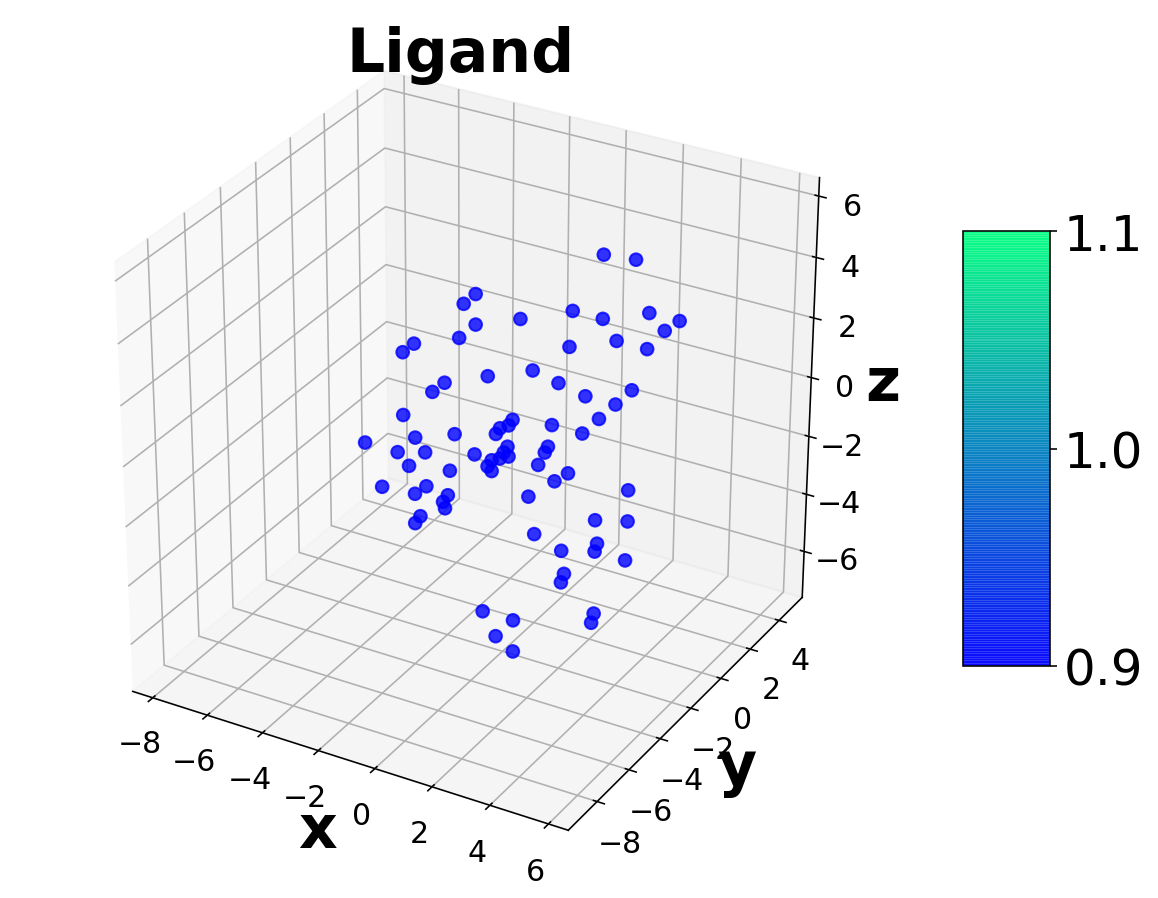

In [17]:
%config InlineBackend.figure_format = 'retina'

chan = 'ligand'
title = 'Ligand'
plt.rc('xtick', labelsize=15)

#field_dict = make_fields(myprotein_dict[0], channels = [chan], bin_size=1.0,num_bins=50, ligand=True, ligand_dict=myprotein_dict[1])
#field_dict = make_fields(myprotein_dict[0], channels = [chan], bin_size=1.0,num_bins=50, ligand=True)
field_dict = voxelize(file_name, channels=[chan], bin_size=1.0,num_bins=30, path_type='file', ligand=True)


plottable=plot_field_test(field_dict[chan],num_bins=30, show=False, title=title, save=True)
# plottable.write_image('test.svg')
# plottable.show()

In [ ]:
field_dict = make_fields(myprotein_dict[0], channels = [chan], bin_size=1.0,num_bins=30, ligand=True, ligand_dict=myprotein_dict[1])

from cnns4qspr import visualizer
plottable=plot_field_test(field_dict[chan],num_bins=30, bin_size=1.0, show=False)
plottable.show()

In [ ]:
import chart_studio

import chart_studio.plotly as py
import chart_studio.tools as tls

username = 'cashraf2'
api_key = 'Vtee5Yc5ttj5N8HFnWgr'

chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

py.plot(plottable, file_name='preotein_ligand', auto_open=False)

In [ ]:
smarts_list = [
                '[#6+0!$(*~[#7,#8,F]),SH0+0v2,s+0,S^3,Cl+0,Br+0,I+0]',
                '[a]',
                '[!$([#1,#6,F,Cl,Br,I,o,s,nX3,#7v5,#15v5,#16v4,#16v6,*+1,*+2,*+3])]',
                '[!$([#6,H0,-,-2,-3]),$([!H0;#7,#8,#9])]',
                '[r]'
            ]

smart_filters = np.array(['hydrophobic', 'aromatic', 'acceptor', 'donor',
                             'ring'])

channel = 'ring'
# smarts_list[smart_filters==channel)]
smarts_list_entry = smarts_list[np.int(np.where(smart_filters == channel)[0])]
molecule = next(pybel.readfile('mol2', '1a1e_ligand.mol2'))
pattern = pybel.Smarts(smarts_list_entry)
atoms_with_prop = np.array(list(*zip(*pattern.findall(molecule))),
                                       dtype=int) - 1
atoms_with_prop

In [ ]:
path = '../../PDBbind/test-set/1a1e/1a1e_ligand.mol2'
file_type = path.split('.')[-1]
file_type

In [ ]:
named_prop = np.array(['hyb', 'heavyvalence', 'heterovalence', 'partialcharge'])

channel = 'partialcharge'

print(index)
prop = []
for atom in pocket:
    #atom.__getattribute__(prop)
    prop.append(atom.__getattribute__(named_prop[np.int(np.where(named_prop == channel)[0])]))

prop = np.array(prop)

normalized_prop =  (prop-min(prop))/(max(prop)-min(prop))
norm_prop = normalized_prop.reshape(73,1)
normalized_prop

In [11]:

"""
This module contains functions to plot atomic density fields before
they go into a model, as well as what the density fields have been
transformed into at certain points within the model.
"""
import torch
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from mpl_toolkits import mplot3d
#from cnns4qspr.featurizer import load_cnn

def outer_block1_hook(module, input_, output):
    global outer_block1_out
    outer_block1_out = output


def outer_block2_hook(module, input_, output):
    global outer_block2_out
    outer_block2_out = output


def outer_block3_hook(module, input_, output):
    global outer_block3_out
    outer_block3_out = output


def outer_block4_hook(module, input_, output):
    global outer_block4_out
    outer_block4_out = output


def outer_block5_hook(module, input_, output):
    global outer_block5_out
    outer_block5_out = output

def plot_field_test(
        field,
        num_bins=50,
        bin_size=1.0,
        color='deep',
        threshold=0.2,
        alpha=0.7,
        show=True,
        title='',
        save=False):
    """
    This function takes a tensorfield and plots the field density in 3D
    space. The field describes an atomic "density" at each voxel.

    Parameters:
        field (pytorch tensor, required): A field from a field
            dictionary that was output by
            either `voxelize` or `make_fields`.

        color (str, optional): The color scheme to plot the field. Any
            of the Plotly continuous color schemes. 'deep' and 'ice_r'
            are recommended as good baselines.

        threshold (float, optional): The threshold intensity that a
            voxel must have in order to be included in the plot.

        alpha (float, optional): Amount of transparency to use in
            plotted marks.

        show (boolean, optional): Whether to show the plot. If false,
            the plotly fig object is returned.

    Returns:
        plotly figure object: If show=False, a plotly figure object is
        returned
    """
    cube = field.reshape(num_bins, num_bins, num_bins)
    #cube /= cube.max()

    cubelist = []
    xval = np.linspace(-len(cube[0]), len(cube[0]), num_bins)
    yval = np.linspace(-len(cube[0]), len(cube[0]), num_bins)
    zval = np.linspace(-len(cube[0]), len(cube[0]), num_bins)
    
    xval = np.linspace(-len(cube[0]) * bin_size / 2.0, len(cube[0]) * bin_size / 2.0, num_bins)
    yval = np.linspace(-len(cube[0]) * bin_size / 2.0, len(cube[0]) * bin_size / 2.0, num_bins)
    zval = np.linspace(-len(cube[0]) * bin_size / 2.0, len(cube[0]) * bin_size / 2.0, num_bins)
    # make a dataframe of x,y,z,intensity for each point in the cube
    # to do this have to loop through the cube
    for i, xval2 in enumerate(xval):

        for j, yval2 in enumerate(yval):

            for k, zval2 in enumerate(zval):

                cubelist.append([xval2, yval2, zval2, cube[i][j][k]])

    cube_df = pd.DataFrame(cubelist, columns=['x', 'y', 'z', 'intensity'])
    

    # only show the voxels with some intensity
    #cube_df = cube_df[cube_df['intensity'] > threshold]
    cube_df = cube_df[cube_df['intensity'] != 0]
#     fig = px.scatter_3d(cube_df, x='x', y='y', z='z',
#                         color='intensity', opacity=alpha,
#                         color_continuous_scale='sunsetdark')
#     fig.update_layout(
#         scene=dict(
#             xaxis=dict(range=[-num_bins / 2.0, num_bins / 2.0]),
#             yaxis=dict(range=[-num_bins / 2.0, num_bins / 2.0]),
#             zaxis=dict(range=[-num_bins / 2.0, num_bins / 2.0])
#         ), title=title
#     )
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x', fontsize=30, fontweight='bold')
    ax.set_ylabel('y', fontsize=30, fontweight='bold')
    ax.set_zlabel('z', fontsize=30, fontweight='bold')
    my_cmap = plt.get_cmap('winter')
    sctt = ax.scatter3D(cube_df['x'], cube_df['y'], cube_df['z'], alpha=0.8,
                        c= cube_df['intensity'], cmap=my_cmap, marker='o', s=40)
    cbar = fig.colorbar(sctt, ax=ax, shrink=0.5, aspect=5)
    cbar.ax.tick_params(labelsize=25)
    ax.set_title(title, fontsize=30, fontweight='bold')
#     fig.update_layout(
#         scene=dict(
#             xaxis=dict(range=[-num_bins / 2.0, num_bins / 2.0]),
#             yaxis=dict(range=[-num_bins / 2.0, num_bins / 2.0]),
#             zaxis=dict(range=[-num_bins / 2.0, num_bins / 2.0])
#         ), title=title
#     )
    plt.show()
    if save==True:
        fig.savefig('fig/figure.png', dpi=600)
    
    if show:
        fig.show()
        figret = None
    else:
        figret = fig
    return figret


In [ ]:
chan = 'partialcharge'

field_dict = make_fields(myprotein_dict[0], channels = [chan], bin_size=1.0,num_bins=30, ligand=True, ligand_dict=myprotein_dict[1])
#field_dict = make_fields(myprotein_dict[0], channels = [chan], bin_size=1.0,num_bins=50, ligand=False)



plottable=plot_field_test(field_dict[chan],num_bins=30, show=False)
plottable.show()

In [ ]:
chan = 'acidic'

field_dict = make_fields(myprotein_dict[0], channels = [chan], bin_size=1.0,num_bins=50, ligand=True, ligand_dict=myprotein_dict[1])
#field_dict = make_fields(myprotein_dict[0], channels = [chan], bin_size=1.0,num_bins=50, ligand=False)


plottable=plot_field_test(field_dict[chan],num_bins=50, show=False)
plottable.show()

In [ ]:
charge = np.loadtxt('charge.out')

import matplotlib.pyplot as plt

x = np.arange(-5, 10, 1)
plt.hist(charge, bins=x)
plt.yscale('log')
plt.show()

In [ ]:
charge[charge >= 3] = 2.9
charge[charge < -3] = -3 

In [ ]:
new = charge // charge.std()

plt.hist(charge, bins=x)
plt.yscale('log')

In [ ]:
def grid_positions(grid_array):
    """
    This function returns the 3D meshgrids of x, y and z positions.
    These cubes will be flattened, then used as a reference coordinate system
    to place the actual channel densities into.
    Parameters:
        grid_positions (pytorch tensor): lineraly spaced grid
    Returns:
        array: meshgrid array of the x, y and z positions.
    """
    xgrid = grid_array.view(-1, 1, 1).repeat(1, len(grid_array), len(grid_array))
    ygrid = grid_array.view(1, -1, 1).repeat(len(grid_array), 1, len(grid_array))
    zgrid = grid_array.view(1, 1, -1).repeat(len(grid_array), len(grid_array), 1)
    return (xgrid, ygrid, zgrid)

def norm_properties(prop, channel):
    
    if channel == 'hyb':
        max_prop = 3
        min_prop = 0
    elif channel == 'heterovalence':
        max_prop = 4
        min_prop = 0
    elif channel == 'heavyvalence':
        max_prop = 4
        min_prop = 0
    else:
        max_prop = 2.276
        min_prop = -1.167
        # clamping the charge value within a range
        # the range is chosen from ligand data
        prop[prop > 2.276] = 2.276
        prop[prop < -1.166] = -1.167
    
    norm_prop = (prop-min_prop)/(max_prop-min_prop)
    
    return norm_prop

def make_fields(protein_dict, channels, bin_size, num_bins, ligand_dict=None, ligand=False):
    """
    This function takes a protein dict (from load_input function) and outputs a
        large tensor containing many atomic "fields" for the protein.
    The fields describe the atomic "density" (an exponentially decaying function
        of number of atoms in a voxel) of any particular atom type.
    Parameters:
        protein_dict (dict, requred): dictionary from the load_input function
        channels (list-like, optional): the different atomic densities we want fields for
            theoretically these different fields provide different chemical information
            full list of available channels is in protein_dict['atom_type_set']
        bin_size (float, optional): the side-length (angstrom) of a given voxel in the box
            that atomic densities are placed in
        num_bins (int, optional): how big is the cubic field tensor side length
            (i.e., num_bins is box side length)
    Returns:
        dictionary: A list of atomic density tensors (50x50x50), one for each
            channel in channels
    """
    # sets of allowed filters to build channels with
    residue_filters = protein_dict['residue_set']
    atom_filters = protein_dict['atom_type_set']
    general_filters = ['all_C', 'all_O', 'all_N']
    residue_property_filters = np.array(['acidic', 'basic', 'polar', 'nonpolar',\
                                         'charged', 'amphipathic'])
    smart_filters = np.array(['hydrophobic', 'aromatic', 'acceptor', 'donor',
                             'ring'])
    named_prop = np.array(['hyb', 'heavyvalence', 'heterovalence', 'partialcharge'])
    protein_ligand_filters = np.array(['protein', 'ligand'])
    #protein_ligand_filters = np.array(['moltype'])
    other_filters = np.array(['backbone', 'sidechains'])

    # consolidate into one set of filters
    filter_set = {'atom':atom_filters, 'residue':residue_filters,\
                  'residue_property':residue_property_filters, \
                  'smarts_property':smart_filters, \
                  'atom_property': named_prop, 'general': general_filters,
                  'protein_ligand': protein_ligand_filters, 'other':other_filters}

    # construct a single empty field, then initialize a dictionary with one
    # empty field for every channel we are going to calculate the density for
    empty_field = torch.zeros(num_bins, num_bins, num_bins).to(device_type)
    fields = {channel:empty_field for channel in channels}

    # create linearly spaced grid (default is -49 to 49 in steps of 2)
    grid_1d = torch.linspace(start=-num_bins / 2 * bin_size + bin_size / 2,
                             end=num_bins / 2 * bin_size - bin_size / 2,
                             steps=num_bins).to(device_type)

    # This makes three 3D meshgrids in for the x, y, and z positions
    # These cubes will be flattened, then used as a reference coordinate system
    # to place the actual channel densities into
    xgrid, ygrid, zgrid = grid_positions(grid_1d)

    for channel_index, channel in enumerate(channels):
        #print(channel)

        # no illegal channels allowed, assume the channel sucks
        channel_allowed = check_channel(channel, filter_set)

        if channel_allowed:
            pass
        else:
            #err_string = 'Allowed channels are: in a protein\'s atom_type_set,
                        # residue_set',or the \'sidechains\' and \'backbone\' channels.'
            raise ValueError('The channel ', channel, ' is not allowed for this protein.')


        # Extract positions of atoms that are part of the current channel

        atom_positions_protein = find_channel_atoms(channel, protein_dict, filter_set)
        
        
        if ligand == True:
            atom_positions_ligand = find_channel_atoms(channel, ligand_dict, filter_set)
            
            if channel == 'protein':
                    atom_positions = atom_positions_protein
        
            elif channel == 'ligand':
                    atom_positions = atom_positions_ligand
            else:
                atom_positions = np.concatenate((atom_positions_protein, atom_positions_ligand))
            #print(atom_positions_protein.shape)
        else:
            atom_positions = atom_positions_protein
        #print(atom_positions.shape)
            
        
        #print('This is channel ', atom_positions)

        atom_positions = torch.FloatTensor(atom_positions).to(device_type)
        

        # xgrid.view(-1, 1) is 125,000 long, because it's viewing a 50x50x50 cube in one column
        # then you repeat that column horizontally for each atom
        xx_xx = xgrid.view(-1, 1).repeat(1, len(atom_positions))
        yy_yy = ygrid.view(-1, 1).repeat(1, len(atom_positions))
        zz_zz = zgrid.view(-1, 1).repeat(1, len(atom_positions))
        
        # at this point we've created 3 arrays that are 125,000 long
        # and as wide as the number of atoms that are the current channel type
        # these 3 arrays just contain the flattened x,y,z positions of our 50x50x50 box


        # now do the same thing as above, just with the ACTUAL atomic position data
        posx_posx = atom_positions[:, 0].contiguous().view(1, -1).repeat(len(xgrid.view(-1)), 1)
        posy_posy = atom_positions[:, 1].contiguous().view(1, -1).repeat(len(ygrid.view(-1)), 1)
        posz_posz = atom_positions[:, 2].contiguous().view(1, -1).repeat(len(zgrid.view(-1)), 1)
        # three tensors of the same size, with actual atomic coordinates

        # normalizes the atomic positions with respect to the center of the box
        # and calculates density of atoms in each voxel
        
        bin_size = torch.tensor(float(bin_size)).to(device_type)
        sigma = 0.5*bin_size

        
        if channel in named_prop:
            prop = []
            for atom in protein_dict['smarts']:
    #atom.__getattribute__(prop)
                prop.append(atom.__getattribute__(named_prop[np.int(np.where(named_prop == channel)[0])]))
            
            if ligand == True:
                for atom in ligand_dict['smarts']:
    #atom.__getattribute__(prop)
                    prop.append(atom.__getattribute__(named_prop[np.int(np.where(named_prop == channel)[0])]))
                
            prop = np.array(prop)

            normalized_prop =  norm_properties(prop, channel)
            normalized_prop =  torch.FloatTensor(normalized_prop).to(device_type)
            #print(normalized_prop)
            if channel == 'partialcharge':
                rev_std = 2.90
                prop = prop + 3.0
                
                prop = np.divide(prop, 0.3448)
            prop =  torch.FloatTensor(prop).to(device_type)
            print(prop.max())
            
            print(normalized_prop.max())
            density = torch.exp(-(((xx_xx - posx_posx)**2) 
                              + ((yy_yy - posy_posy)**2)
                              + ((zz_zz - posz_posz)**2)) * prop / (2 * (sigma)**2)
                              )
            print(density.max())
        else:
            density = torch.exp(-((xx_xx - posx_posx)**2
                            + (yy_yy - posy_posy)**2
                            + (zz_zz - posz_posz)**2) / (2 * (sigma)**2))
        

        # Normalize so each atom density sums to one
        density /= torch.sum(density, dim=0)

        # Sum densities and reshape to original shape
        sum_densities = torch.sum(density, dim=1).view(xgrid.shape)
        print(sum_densities.shape)
        print(density.shape)

        # set all nans to 0
        sum_densities[sum_densities != sum_densities] = 0

        # add two empty dimmensions to make it 1x1x50x50x50, needed for CNN
        # sum_densities = sum_densities.unsqueeze(0)
        # sum_densities = sum_densities.unsqueeze(0)

        #fields[atom_type_index] = sum_densities
        fields[channel] = sum_densities.numpy()

#     if return_bins:
#         return fields, num_bins
#     else:
    return fields

def check_channel(channel, filter_set):
    """
    This function checks to see if a channel the user is asking to make a field
        for is an allowed channel to ask for.
    Parameters:
        channel (str, required): The atomic channel being requested
        filter_set (dict, required): The set of defined atomic filters
    Returns:
        boolean: indicator for if the channel is allowed
    """
    channel_allowed = False
    for key in filter_set:
        if channel in filter_set[key]:
            channel_allowed = True

    return channel_allowed

def find_channel_atoms(channel, protein_dict, filter_set):
    """
    This function finds the coordinates of all relevant atoms in a channel.
    It uses the filter set to constrcut the atomic channel (i.e., a channel can
        be composed of multiple filters).
    Parameters:
        channel (str, required): The atomic channel being constructed
        protein_dict (dict, required): The dictionary of the protein, returned from
            load_input()
        filter_set (dict, required): The set of available filters to construct channels with
    Returns:
        numpy array:  array containing the coordinates of each atom that is relevant
            to the channel
    """
    if channel in filter_set['atom']:
        atom_positions = protein_dict['shifted_positions'][protein_dict['atom_types'] == channel]
    
    
    elif channel in filter_set['general']:
        atom_dict = {'all_C' :'C', 'all_O' : 'O', 'all_N' : 'N'}
        atom_positions = protein_dict['shifted_positions']\
                        [[a.startswith(atom_dict[channel], 0) for a in protein_dict['atom_types']]]

    elif channel in filter_set['residue']:
        atom_positions = protein_dict['shifted_positions'][protein_dict['residues'] == channel]
        
    elif channel in filter_set['smarts_property']:
        smarts_list = [
                '[#6+0!$(*~[#7,#8,F]),SH0+0v2,s+0,S^3,Cl+0,Br+0,I+0]',
                '[a]',
                '[!$([#1,#6,F,Cl,Br,I,o,s,nX3,#7v5,#15v5,#16v4,#16v6,*+1,*+2,*+3])]',
                '[!$([#6,H0,-,-2,-3]),$([!H0;#7,#8,#9])]',
                '[r]'
            ]
        smarts_list_entry = smarts_list[np.int(np.where(filter_set['smarts_property'] == channel)[0])]
        pattern = pybel.Smarts(smarts_list_entry)
        atoms_smart = np.array(list(*zip(*pattern.findall(protein_dict['smarts']))),
                                    dtype=int) - 1
        #print(atoms_smart)
        atom_positions = protein_dict['shifted_positions'][atoms_smart]
    
    elif channel in filter_set['atom_property']:
        atom_positions = protein_dict['shifted_positions']
        
    elif channel in filter_set['protein_ligand']:
        atom_positions = protein_dict['shifted_positions']

    elif channel in filter_set['other']: # backbone or sidechain
        if channel == 'backbone':
            # create boolean arrays for backbone atoms
            bool_oxygen = protein_dict['atom_types'] == 'O'
            bool_carbon = protein_dict['atom_types'] == 'C'
            bool_alphacarbon = protein_dict['atom_types'] == 'CA'
            bool_nitrogen = protein_dict['atom_types'] == 'N'

            # sum of all the backbone channels into one boolean array
            bool_backbone = bool_oxygen + bool_carbon + bool_alphacarbon + bool_nitrogen

            # select the backbone atoms
            atom_positions = protein_dict['shifted_positions'][bool_backbone]

        else: # it was 'sidechain' filter, so grab sidechain atoms
            backbone_atom_set = np.array(['O', 'C', 'CA', 'N'])
            sidechain_atom_set = np.array([atom for atom in protein_dict['atom_type_set'] \
                                           if atom not in backbone_atom_set])

            for index, sidechain_atom in enumerate(sidechain_atom_set):
                if index == 0:
                    # create the first sidechains boolean array, will be edited
                    bool_sidechains = protein_dict['atom_types'] == sidechain_atom
                else:
                    # single boolean array for the current sidechain atom
                    bool_atom = protein_dict['atom_types'] == sidechain_atom

                    # sum this boolean array with the master boolean array
                    bool_sidechains += bool_atom

            # grab all sidechain atom positions
            atom_positions = protein_dict['shifted_positions'][bool_sidechains]

    else: # it was a residue property channel
        acidic_residues = np.array(['ASP', 'GLU'])
        basic_residues = np.array(['LYS', 'ARG', 'HIS'])
        polar_residues = np.array(['GLN', 'ASN', 'HIS', 'SER', 'THR', 'TYR', 'CYS'])
        nonpolar_residues = np.array(['GLY', 'ALA', 'VAL', 'LEU', \
                                        'ILE', 'MET', 'PRO', 'PHE', 'TRP'])
        amphipathic_residues = np.array(['TRP', 'TYR', 'MET'])
        charged_residues = np.array(['ARG', 'LYS', 'ASP', 'GLU'])
        # custom_residues = something
        property_dict = {'acidic':acidic_residues, 'basic':basic_residues,\
                         'polar':polar_residues, 'nonpolar':nonpolar_residues,\
                         'amphipathic':amphipathic_residues, 'charged':charged_residues}

        atom_positions = atoms_from_residues(protein_dict, property_dict[channel])

    return atom_positions

def atoms_from_residues(protein_dict, residue_list):
    """
    This function finds all the atoms in a protein that are members of any residues
    in a list of residues.
    Parameters:
        protein_dict (dict, required): The dictionary of the protein, returned from
            load_input()
        residue_list (list-like, required): The list of residues whose atoms we are
            finding coordinates for
    """
    # construct the appropriate boolean array to index the atoms in the protein_dict
    for index, residue in enumerate(residue_list):
        if index == 0:
            bool_residue = protein_dict['residues'] == residue
        else:
            bool_residue += protein_dict['residues'] == residue

    atom_positions = protein_dict['shifted_positions'][bool_residue]

    return atom_positions

def voxelize(path, channels=['CA'], path_type='file', ligand=False, bin_size=2.0, num_bins=50, save=False, save_fn='voxels.npy', save_path='./'):
    """
    This function creates a dictionary of tensor fields directly from a pdb file.
    These tensor fields can be plotted, or sent directly into the cnn for
        plotting internals, or sent all the way through a cnn/vae to be used for
        training.
    Parameters:
        path (str, required): path to a .pdb file
        channels (list of strings, optional): The list of atomic channels to be included in
            the output dictionary, one field for every channel.
            Any channels from points 1-4 below may be combined in any order.
            i.e., one could call voxelize with the channels parameter as
            channels=['charged', 'CB', 'GLY', 'polar', ...etc]. Note that voxelization
            for channels containing more atoms will take longer.
            1. any of the following atom types
                ['C' 'CA' 'CB' 'CD' 'CD1' 'CD2' 'CE' 'CE1' 'CE2' 'CE3' 'CG' 'CG1' 'CG2'
                'CH2' 'CZ' 'CZ2' 'CZ3' 'N' 'ND1' 'ND2' 'NE' 'NE1' 'NE2' 'NH1' 'NH2' 'NZ'
                'O' 'OD1' 'OD2' 'OE1' 'OE2' 'OG' 'OG1' 'OH' 'OXT' 'SD' 'SG']
            2. Any canonical residue in the protein, using the three letter residue code, all caps
               (NOTE: the residue must actually exist in the protein)
                e.g., ['LYS', 'LEU', 'ALA']
            3. The 'other' channel options: 'backbone', 'sidechains'
            4. There are 6 channels corresponding to specific types of residues:
                'charged', 'polar', 'nonpolar', 'amphipathic', 'acidic', 'basic'
    Returns:
        dictionary: a dictionary containing a voxelized atomic fields, one for each
        channel requested. Each field has shape = ([1, 1, 50, 50, 50])
    """
    if path_type == 'file':
        pro_dict = load_input(path, ligand=ligand)
        if ligand == True:
            protein_dict = pro_dict[0]
            ligand_dict = pro_dict[1]
            return make_fields(protein_dict, channels=channels, bin_size=bin_size, num_bins=num_bins, ligand=True, ligand_dict=ligand_dict)
        else:
            protein_dict = pro_dict
            sys.stdout.write('done')
            return make_fields(protein_dict, channels=channels, bin_size=bin_size, num_bins=num_bins)

    # ------------FOLDER FUNCTIONALITY INCOMPLETE---------------
    elif path_type == 'folder':
        fields = []
        pdb_fns = os.listdir(path)
        for j, fn in enumerate(pdb_fns):
            progress = '{}/{} pdbs voxelized ({}%)'.format(j, len(pdb_fns), \
                        round(j / len(pdb_fns) * 100, 2))
            sys.stdout.write('\r'+progress)
            protein_dict = load_input(os.path.join(path, fn))
            field, bins = make_fields(protein_dict, channels=channels, bin_size=bin_size, num_bins=num_bins)
            channel_list = []
            for channel in channels:
                channel_list.append(field[channel].reshape(1,
                                                           bins,
                                                           bins,
                                                           bins))
            field = np.concatenate(channel_list).reshape(1,len(channels),
                                                         bins, bins, bins)
            fields.append(field)
        sys.stdout.write("\r\033[K")
        out_statement = 'voxelization complete!\n'
        sys.stdout.write('\r'+out_statement)
        fields = np.concatenate(fields)

        if save:
            np.save(os.path.join(save_path, save_fn), fields)
        else:
            return fields